To access data and model files

In [3]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
!pip install hyperas
#!ln -s "/gdrive/My Drive/ML Final Project/Code" 

Mounted at /content/drive/


In [34]:
from numpy.random.mtrand import randint
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import normal
import random

def jittering(v, p, col, n_test, sd=0.01):
  #v: data vector, p: how many data in percentage, col: col number 
  #According to the length 'n' of vector, we create a noise vector that length n with 
  #a normal distribution N(0, sd). The standard deviation can be our parameter of noise generator
  if p==0 or sd == 0: return v
  n = n_test
  #generate sample of n values that follow a normal distribution 
  # Create Figure and Subplots
  plt.plot(v[:,col],linewidth=2.0, label='raw')
  indexs = []
  for i in range(49563 , 49563 + n):
    indexs.append(i)
  jittering_size = round(n * p)
  #make this example reproducible
  seed(1)
  picked_index = random.choices(indexs, k=jittering_size)
  #Standard deviation for noise vectoy depends on range of data, (max - min)
  noise_sd = np.var(v[:,col]) * sd
  seed(1)
  noise_vector = normal(loc=0, scale=noise_sd, size=jittering_size)
  noise_index = 0
  for i in picked_index:
    rand = random.random()
    if(rand<p):
      v[i,col] += noise_vector[noise_index]
    noise_index += 1
  plt.plot(v[:,col],linewidth=1.0, label='noise added')
  plt.title("Jittering data with p = " + str(p) + " sd = " + str(noise_sd))
  plt.legend()
  plt.show()
  return v

#Retrieve Data and apply jittering on part of the train data

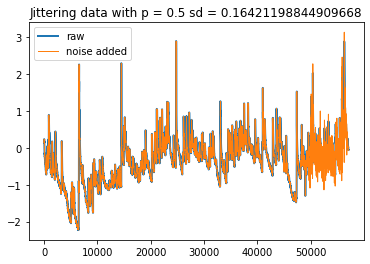

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)


In [35]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
import keras.backend as K
from tensorflow.compat.v1.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from keras.layers import Activation
#from keras.utils import plot_model, np_utils
from keras.utils.vis_utils import plot_model
from keras.regularizers import L1L2
from hyperas import optim
from hyperas.distributions import choice, uniform
#from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random as rn
import os
import torch
#retrieve data
def data_jittering(p=0, sd=0):
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
        agg = concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    n_lags = 26
    n_ahead = 19
    n_train = 49563
    n_test = 7234

    dataset_raw = read_csv("/content/drive/MyDrive/MMPS_043_no_blanks.csv",
                           index_col=None, parse_dates=True, infer_datetime_format=True)

    train_dates = dataset_raw[['Datetime', 'GWL', 'Tide', 'Precip.Avg']].iloc[:n_train]
    test_dates = dataset_raw[['Datetime', 'GWL', 'Tide', 'Precip.Avg']].iloc[n_train:]
    test_dates = test_dates.reset_index(drop=True)
    test_dates['Datetime'] = pd.to_datetime(test_dates['Datetime'])

    dataset = dataset_raw.drop(dataset_raw.columns[[0, 3, 4, 5, 6]], axis=1)

    values = dataset.values
    values = values.astype('float32')
    #calling jittering function 
    values = jittering(values, p, 0, n_test, sd)
    
    gwl = values[:, 0]
    gwl = gwl.reshape(gwl.shape[0], 1)

    tide = values[:, 1]
    tide = tide.reshape(tide.shape[0], 1)

    rain = values[:, 2]
    rain = rain.reshape(rain.shape[0], 1)

    gwl_scaler, tide_scaler, rain_scaler = MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    gwl_scaled = gwl_scaler.fit_transform(gwl)
    tide_scaled = tide_scaler.fit_transform(tide)
    rain_scaled = rain_scaler.fit_transform(rain)
    df = DataFrame(gwl_scaled)
    
    gwl_super = series_to_supervised(gwl_scaled, n_lags, n_ahead)
    gwl_super_values = gwl_super.values
    tide_super = series_to_supervised(tide_scaled, n_lags, n_ahead)
    tide_super_values = tide_super.values
    rain_super = series_to_supervised(rain_scaled, n_lags, n_ahead)
    rain_super_values = rain_super.values

    gwl_input, gwl_labels = gwl_super_values[:, 0:n_lags + 1], gwl_super_values[:, n_lags + 1:]

    train_X = np.concatenate((gwl_input[:n_train, :], tide_super_values[:n_train, :], rain_super_values[:n_train, :]),
                             axis=1)
    test_X = np.concatenate((gwl_input[49563:56797, :], tide_super_values[49563:56797, :], rain_super_values[49563:56797, :]),
                            axis=1)
    train_y, test_y = gwl_labels[:n_train, :], gwl_labels[49563:56797, :]

    
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y, gwl_scaler, test_dates

train_X, train_y, test_X, test_y, gwl_scaler, test_dates = data_jittering(0, 0)



#Create Optimal Model
Change model path

In [ ]:
"""
This network uses the last 26 observations of gwl, tide, and rain to predict the next 18
values of gwl for well MMPS-043
"""

import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
import keras.backend as K
from tensorflow.compat.v1.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from keras.layers import Activation
#from keras.utils import plot_model, np_utils
from keras.utils.vis_utils import plot_model
from keras.regularizers import L1L2
from hyperas import optim
from hyperas.distributions import choice, uniform
#from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random as rn
import os
import torch
matplotlib.rcParams.update({'font.size': 8})


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)


def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


def data():
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
        agg = concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    n_lags = 26
    n_ahead = 19
    n_train = 49563

    dataset_raw = read_csv("/content/drive/MyDrive/ML Final Project/Code/MMPS_043_no_blanks.csv",
                           index_col=None, parse_dates=True, infer_datetime_format=True)

    train_dates = dataset_raw[['Datetime', 'GWL', 'Tide', 'Precip.Avg']].iloc[:n_train]
    test_dates = dataset_raw[['Datetime', 'GWL', 'Tide', 'Precip.Avg']].iloc[n_train:]
    test_dates = test_dates.reset_index(drop=True)
    test_dates['Datetime'] = pd.to_datetime(test_dates['Datetime'])

    dataset = dataset_raw.drop(dataset_raw.columns[[0, 3, 4, 5, 6]], axis=1)

    values = dataset.values
    values = values.astype('float32')

    gwl = values[:, 0]
    gwl = gwl.reshape(gwl.shape[0], 1)

    tide = values[:, 1]
    tide = tide.reshape(tide.shape[0], 1)

    rain = values[:, 2]
    rain = rain.reshape(rain.shape[0], 1)

    gwl_scaler, tide_scaler, rain_scaler = MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    gwl_scaled = gwl_scaler.fit_transform(gwl)
    tide_scaled = tide_scaler.fit_transform(tide)
    rain_scaled = rain_scaler.fit_transform(rain)

    gwl_super = series_to_supervised(gwl_scaled, n_lags, n_ahead)
    gwl_super_values = gwl_super.values
    tide_super = series_to_supervised(tide_scaled, n_lags, n_ahead)
    tide_super_values = tide_super.values
    rain_super = series_to_supervised(rain_scaled, n_lags, n_ahead)
    rain_super_values = rain_super.values

    gwl_input, gwl_labels = gwl_super_values[:, 0:n_lags + 1], gwl_super_values[:, n_lags + 1:]

    train_X = np.concatenate((gwl_input[:n_train, :], tide_super_values[:n_train, :], rain_super_values[:n_train, :]),
                             axis=1)
    test_X = np.concatenate((gwl_input[49563:56797, :], tide_super_values[49563:56797, :], rain_super_values[49563:56797, :]),
                            axis=1)
    train_y, test_y = gwl_labels[:n_train, :], gwl_labels[49563:56797, :]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y, gwl_scaler, test_dates


def create_model(train_X, train_y, test_X, test_y):
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

    n_ahead = 19
    n_test = 7548
    n_epochs = 1000
    n_neurons = 10
    n_batch = 49563

    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    rn.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.compat.v1.set_random_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    tf.compat.v1.keras.backend.set_session(sess) 
    
    model = Sequential()
    model.add(LSTM(units={{choice([10, 15, 20, 40, 50, 75])}}, activation={{choice(['relu', 'tanh', 'sigmoid'])}},
                   input_shape=(train_X.shape[1], train_X.shape[2]), use_bias=True,
                   bias_regularizer=L1L2(l1=0.01, l2=0.01)))
    model.add(Dropout({{uniform(0.1, 0.5)}}))
    model.add(Dense(activation='linear', units=n_ahead-1, use_bias=True))

    adam = tf.keras.optimizers.Adam(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})
    rmsprop = tf.keras.optimizers.RMSprop(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})
    sgd = tf.keras.optimizers.SGD(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})

    choiceval = {{choice(['adam', 'gsd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd

    model.compile(loss=rmse, optimizer=optim)

    earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00000001, patience=5, verbose=1, mode='auto')
    model.fit(train_X, train_y, batch_size=n_batch, epochs=n_epochs, verbose=2, shuffle=False, callbacks=[earlystop])
    loss = model.evaluate(test_X, test_y, batch_size=n_test, verbose=0)
    return {'loss': loss, 'status': STATUS_OK, 'model': model}


if __name__ == '__main__':
    n_ahead = 19
    n_lags = 26

    path = "/content/drive/MyDrive/ML Final Project/Code/"

    best_run, best_model = optim.minimize(model=create_model, data=data, algo=tpe.suggest, max_evals=100, trials=Trials(), notebook_name='/drive/MyDrive/ML Final Project/Code/MLFinalProject')
    train_X, train_y, test_X, test_y, gwl_scaler, test_dates = data()
    best_model.save('/content/drive/MyDrive/ML Final Project/Code/best_model_so_far') # save best model, so we don't have to run optimize code again or fit the model
    print("Best performing model chosen hyper-parameters:")
    print(best_run)


ModuleNotFoundError: ignored

# Load optimal model
point to the correct model

In [38]:
import keras
#using best model above
# 100 evals {'Dropout': 0.24505392260227796, 'activation': 1,'choiceval': 0, 'lr': 0, 'lr_1': 2, 'lr_2': 0, 'units': 5} 
#Best performing model chosen hyper-parameters:
{'Dropout': 0.1394143626335395, 'activation': 1, 'choiceval': 2, 'lr': 2, 'lr_1': 0, 'lr_2': 0, 'units': 1}
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
model = keras.models.load_model('/content/drive/MyDrive/ML Final Project/Code/best_model_so_far', custom_objects={'rmse': rmse})#retrieves saved best model


In [71]:
model.fit(train_X, train_y)

1549/1549 [==============================] - 5s 3ms/step - loss: 0.0179


Calculate Errors

In [8]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)


def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [72]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)


y_pred = model.predict(test_X)
print("MSE: ")
print(mse(test_y, y_pred))
px = pd.DataFrame(mse(test_y, y_pred).numpy())
print("Mean of MSE tensor:")
print(px.mean(0))
print("MAE: ")
print(mae(test_y, y_pred))
print("Mean of MAE tensor:")
px = pd.DataFrame(mae(test_y, y_pred).numpy())
print(px.mean(0))
print("RMSE: ")
print(rmse(test_y, y_pred))
print("Mean of RMSE tensor:")
px = pd.DataFrame(rmse(test_y, y_pred).numpy())
print(px.mean(0))


MSE: 
tf.Tensor(
[9.1592279e-05 8.2728169e-05 7.5359712e-05 ... 1.5062871e-03 1.5316146e-03
 1.6267817e-03], shape=(7234,), dtype=float32)
Mean of MSE tensor:
0    0.001683
dtype: float32
MAE: 
tf.Tensor([0.00803176 0.00771023 0.00733613 ... 0.03874581 0.03906862 0.04028032], shape=(7234,), dtype=float32)
Mean of MAE tensor:
0    0.026136
dtype: float32
RMSE: 
tf.Tensor([0.00957038 0.0090955  0.008681   ... 0.03881092 0.03913585 0.04033338], shape=(7234,), dtype=float32)
Mean of RMSE tensor:
0    0.0274
dtype: float32


In [18]:
p_array = np.arange(0, 0.5, 0.01)
print(len(p_array))

50


Try different porportion to add jittering with p = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)


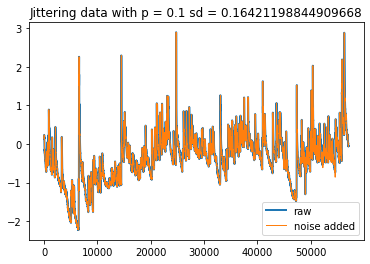

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)


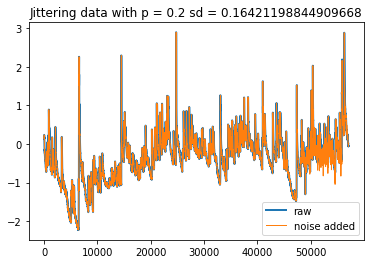

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)


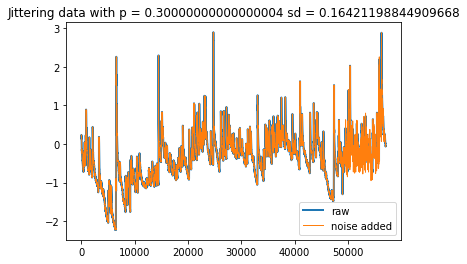

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)


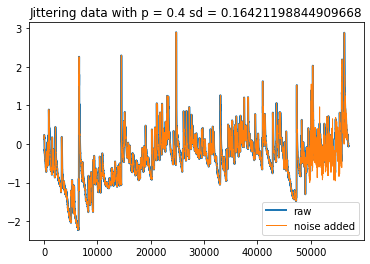

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)


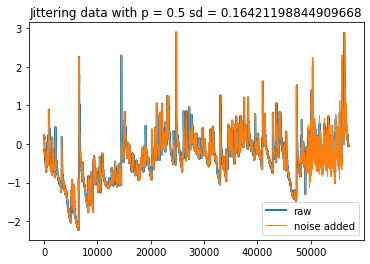

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)


In [43]:
mse_ls = []
mae_ls = []
rmse_ls = []
p_array = np.arange(0, 0.51, 0.1)
for i in p_array:
  train_X, train_y, test_X, test_y, gwl_scaler, test_dates = data_jittering(i, 0.5)
  y_pred = model.predict(test_X)
  #mse
  mse(test_y, y_pred)
  px = pd.DataFrame(mse(test_y, y_pred).numpy())
  mse_ls.append(px.mean(0))
  #mae
  mae(test_y, y_pred)
  px = pd.DataFrame(mae(test_y, y_pred).numpy())
  mae_ls.append(px.mean(0))
  #rmse
  rmse(test_y, y_pred)

[0    0.000841
dtype: float32, 0    0.00085
dtype: float32, 0    0.000886
dtype: float32, 0    0.000957
dtype: float32, 0    0.001025
dtype: float32, 0    0.001104
dtype: float32]
Increasing rate for 1
0    0.010877
dtype: float32
Increasing rate for 2
0    0.053494
dtype: float32
Increasing rate for 3
0    0.138072
dtype: float32
Increasing rate for 4
0    0.218442
dtype: float32
Increasing rate for 5
0    0.312409
dtype: float32
[0    0.01935
dtype: float32, 0    0.019489
dtype: float32, 0    0.01995
dtype: float32, 0    0.020782
dtype: float32, 0    0.021697
dtype: float32, 0    0.022582
dtype: float32]


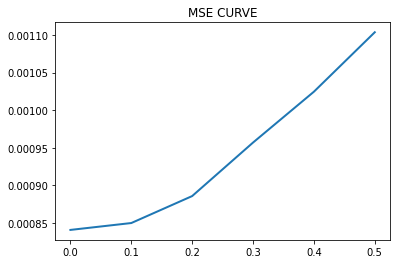

In [46]:

print(mse_ls)
plt.title("MSE CURVE")
plt.plot(p_array, mse_ls, linewidth=2, markersize=12)
for j in range(1,len(mse_ls)):
  print("Increasing rate for "+ str(j))
  print((mse_ls[j] - mse_ls[0])/mse_ls[0])

print(mae_ls)
# plt.title("MAE CURVE")
# plt.plot([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], mae_ls, linewidth=2, markersize=12)

Try different strength of adding jiterring noise

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)
1549/1549 [==============================] - 8s 5ms/step - loss: 0.0182


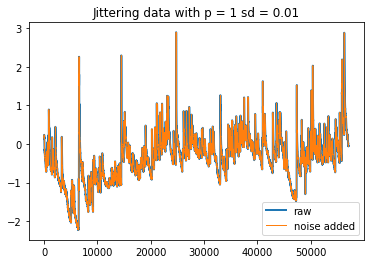

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)
1549/1549 [==============================] - 4s 3ms/step - loss: 0.0182


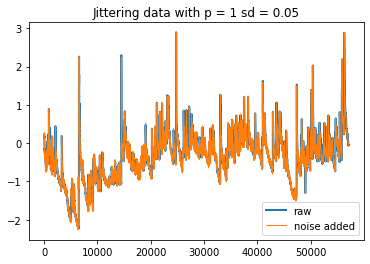

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)
1549/1549 [==============================] - 4s 3ms/step - loss: 0.0187


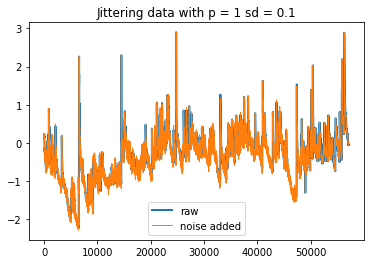

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)
1549/1549 [==============================] - 4s 3ms/step - loss: 0.0200


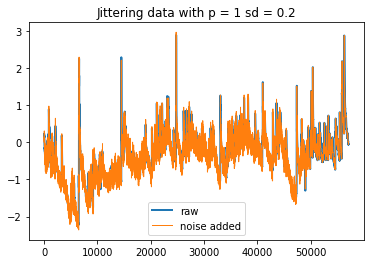

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)
1549/1549 [==============================] - 4s 3ms/step - loss: 0.0234


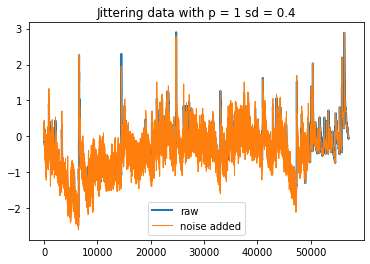

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)
1549/1549 [==============================] - 4s 3ms/step - loss: 0.0327


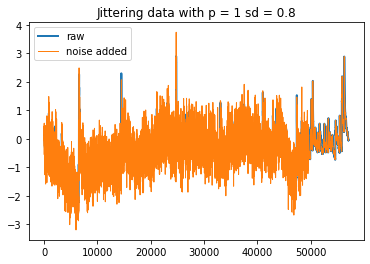

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)
1549/1549 [==============================] - 4s 3ms/step - loss: 0.0435


In [20]:
mse_ls = []
mae_ls = []
rmse_ls = []

for j in [0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8]:
  train_X, train_y, test_X, test_y, gwl_scaler, test_dates = data_jittering(1, j)
  model.fit(train_X, train_y)
  y_pred = model.predict(test_X)
  #mse
  mse(test_y, y_pred)
  px = pd.DataFrame(mse(test_y, y_pred).numpy())
  mse_ls.append(px.mean(0))
  #mae
  mae(test_y, y_pred)
  px = pd.DataFrame(mae(test_y, y_pred).numpy())
  mae_ls.append(px.mean(0))
  #rmse
  rmse(test_y, y_pred)

[0    0.001083
dtype: float32, 0    0.001333
dtype: float32, 0    0.001393
dtype: float32, 0    0.001087
dtype: float32, 0    0.000892
dtype: float32, 0    0.00107
dtype: float32, 0    0.000708
dtype: float32]
[0    0.018374
dtype: float32, 0    0.021771
dtype: float32, 0    0.022643
dtype: float32, 0    0.018333
dtype: float32, 0    0.017443
dtype: float32, 0    0.018446
dtype: float32, 0    0.019331
dtype: float32]
[]


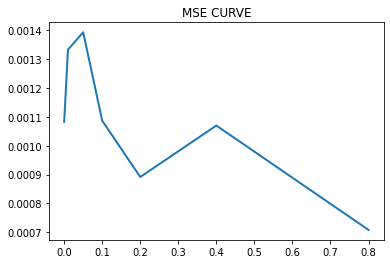

In [23]:
print(mse_ls)
plt.title("MSE CURVE")
plt.plot([0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8], mse_ls, linewidth=2, markersize=12)
print(mae_ls)
print(rmse_ls)

Plot Curve

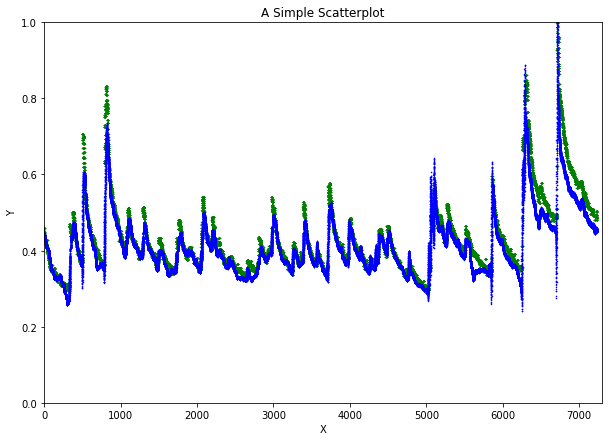

In [27]:

x_axis = list(range(1, len(y_pred)+1))
plt.figure(figsize=(10,7)) # 10 is width, 7 is height
plt.plot(x_axis, test_y, 'g*', label='GreenDots', markersize=1)  # green dots
plt.plot(x_axis, y_pred, 'b*', label='Bluestars', markersize=1)  # blue stars
plt.title('A Simple Scatterplot')  
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(0, 7300)
plt.ylim(0, 1)
plt.show()